In [83]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

import matplotlib.pyplot as plt
import numpy as np
import cv2

import os, json, shutil
from tensorflow.keras.preprocessing.image import load_img

train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/train'

val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/val'

sources to help this notebook run  
https://stackoverflow.com/questions/56517963/keras-imagedatagenerator-for-segmentaion-with-images-and-masks-in-separate-direc  
https://github.com/keras-team/keras/issues/3059  
https://stackoverflow.com/questions/60787620/combine-two-data-generator-to-train-a-cnn


In [ ]:
# all_images = list(os.listdir(data_dir  + '/val/masks'))


# for img in all_images:
# #         shutil.move(os.path.join(root_dir, "images", img), os.path.join(save_dir, "images"))
#         shutil.move(os.path.join(data_dir  + '/val/masks', img) , os.path.join(data_dir  + '/val/masks' , img.replace( "_mask.png" ,".png")) )

In [73]:
class MergedGenerators(Sequence):
    def __init__(self, batch_size, generators=[]):
        self.generators = generators
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generators[0])

    def __getitem__(self, index):
        return [generator[index] for generator in self.generators]

In [74]:
def build_datagenerator(dir1=None, batch_size=32):
    
    img_rows = 512
    img_cols = 512
    
    
    n_images_in_dir1 = sum([len(files) for r, d, files in os.walk(dir1)])

    # Have to set different batch size for two generators as number of images
    # in those two directories are not same. As we have to equalize the image
    # share in the generators
#     generator1_batch_size = int((n_images_in_dir1 * batch_size) /
#                                 (n_images_in_dir1 + n_images_in_dir2))

#     generator2_batch_size = batch_size - generator1_batch_size

#     generator1 = ImageDataGenerator(
#         rescale=1. / 255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         rotation_range=5.,
#         horizontal_flip=True,
#     )

#     generator2 = ImageDataGenerator(
#         rescale=1. / 255,
#         zoom_range=0.2,
#         horizontal_flip=False,
#     )

    generator1 = ImageDataGenerator(
        rescale=1. / 255
    )

    generator2 = ImageDataGenerator(
        rescale=1. / 255
    )

    # generator2 has different image augmentation attributes than generaor1
    generator1 = generator1.flow_from_directory(
        dir1,
        target_size=(img_rows,img_cols),
        color_mode='rgb',
        classes=['images'],
        class_mode=None,
        batch_size=batch_size,
        seed=42
    )
    
    generator2 = generator2.flow_from_directory(
        dir1 ,
        target_size=(img_rows,img_cols),
        color_mode='grayscale',
        classes=['masks'],
        class_mode=None,
        batch_size=batch_size,
        seed=42
    )

    return MergedGenerators(
        batch_size,
        generators=[generator1, generator2])

#     return zip(generator1, generator2)

In [80]:
class gen_data(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [104]:
train_input_img_paths = sorted(
    [
        os.path.join(train_data_dir + '/images', fname)
        for fname in os.listdir(train_data_dir + '/images')
        if fname.endswith(".png")
    ]
)

train_target_img_paths = sorted(
    [
        os.path.join(train_data_dir + '/masks', fname)
        for fname in os.listdir(train_data_dir + '/images')
        if fname.endswith(".png")
    ]
)


val_input_img_paths = sorted(
    [
        os.path.join(val_data_dir + '/images', fname)
        for fname in os.listdir(train_data_dir + '/images')
        if fname.endswith(".png")
    ]
)

val_target_img_paths = sorted(
    [
        os.path.join(val_data_dir + '/masks', fname)
        for fname in os.listdir(train_data_dir + '/images')
        if fname.endswith(".png")
    ]
)


In [107]:
# train_generator = build_datagenerator(dir1=train_data_dir, batch_size=32)
# val_generator = build_datagenerator(dir1=val_data_dir, batch_size=32)
batch_size = 32
img_size = (512,512)


train_generator = gen_data(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_generator = gen_data(batch_size, img_size, val_input_img_paths, val_target_img_paths)



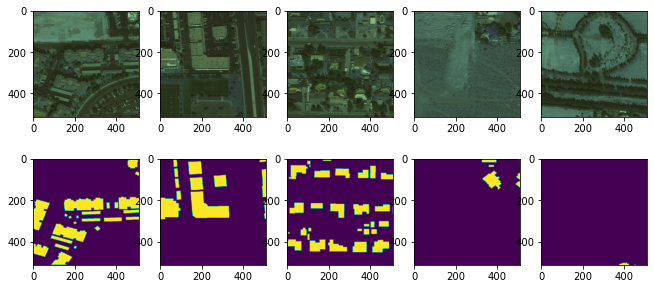

In [33]:
fig, axes = plt.subplots(2, 5, figsize=(11, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,5):
    
    image = train_generator[5][0][a+5,:,:,:]

    # Load masks
    mask = train_generator[5][1][a+5,:,:,:]
    
    
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [69]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((512,512), 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [109]:
# STEP_SIZE_TRAIN=len(train_generator)//train_generator.batch_size
# STEP_SIZE_VALID=len(train_generator)//train_generator.batch_size


# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# model.fit_generator(generator=train_generator[1][0],
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=train_generator[1][1],
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=1
# )


model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# callbacks = [
#     keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
# ]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_generator, epochs=5, validation_data=val_generator)


# model.fit_generator(
#     train_generator,
#     steps_per_epoch=int(len(train_generator) // train_generator.batch_size), 
#     epochs=20,
#     max_queue_size=35,
#     workers=35,
#     use_multiprocessing=True,
#     shuffle=False,
#     callbacks=[noise_cb, tqdm_cb],
#     verbose=0,
# )

Epoch 1/5


KeyboardInterrupt: 